# 循环神经网络
:label:`sec_rnn`

在 :numref:`sec_language_model`中，
我们介绍了$n$元语法模型，
其中单词$x_t$在时间步$t$的条件概率仅取决于前面$n-1$个单词。
对于时间步$t-(n-1)$之前的单词，
如果我们想将其可能产生的影响合并到$x_t$上，
需要增加$n$，然而模型参数的数量也会随之呈指数增长，
因为词表$\mathcal{V}$需要存储$|\mathcal{V}|^n$个数字，
因此与其将$P(x_t \mid x_{t-1}, \ldots, x_{t-n+1})$模型化，
不如使用隐变量模型：

$$P(x_t \mid x_{t-1}, \ldots, x_1) \approx P(x_t \mid h_{t-1}),$$

其中$h_{t-1}$是*隐状态*（hidden state），
也称为*隐藏变量*（hidden variable），
它存储了到时间步$t-1$的序列信息。
通常，我们可以基于当前输入$x_{t}$和先前隐状态$h_{t-1}$
来计算时间步$t$处的任何时间的隐状态：

$$h_t = f(x_{t}, h_{t-1}).$$
:eqlabel:`eq_ht_xt`

对于 :eqref:`eq_ht_xt`中的函数$f$，隐变量模型不是近似值。
毕竟$h_t$是可以仅仅存储到目前为止观察到的所有数据，
然而这样的操作可能会使计算和存储的代价都变得昂贵。

回想一下，我们在 :numref:`chap_perceptrons`中
讨论过的具有隐藏单元的隐藏层。
值得注意的是，隐藏层和隐状态指的是两个截然不同的概念。
如上所述，隐藏层是在从输入到输出的路径上（以观测角度来理解）的隐藏的层，
而隐状态则是在给定步骤所做的任何事情（以技术角度来定义）的*输入*，
并且这些状态只能通过先前时间步的数据来计算。

*循环神经网络*（recurrent neural networks，RNNs）
是具有隐状态的神经网络。
在介绍循环神经网络模型之前，
我们首先回顾 :numref:`sec_mlp`中介绍的多层感知机模型。

## 无隐状态的神经网络

让我们来看一看只有单隐藏层的多层感知机。
设隐藏层的激活函数为$\phi$，
给定一个小批量样本$\mathbf{X} \in \mathbb{R}^{n \times d}$，
其中批量大小为$n$，输入维度为$d$，
则隐藏层的输出$\mathbf{H} \in \mathbb{R}^{n \times h}$通过下式计算：

$$\mathbf{H} = \phi(\mathbf{X} \mathbf{W}_{xh} + \mathbf{b}_h).$$
:eqlabel:`rnn_h_without_state`

在 :eqref:`rnn_h_without_state`中，
我们拥有的隐藏层权重参数为$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}$，
偏置参数为$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及隐藏单元的数目为$h$。
因此求和时可以应用广播机制（见 :numref:`subsec_broadcasting`）。
接下来，将隐藏变量$\mathbf{H}$用作输出层的输入。
输出层由下式给出：

$$\mathbf{O} = \mathbf{H} \mathbf{W}_{hq} + \mathbf{b}_q,$$

其中，$\mathbf{O} \in \mathbb{R}^{n \times q}$是输出变量，
$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$是权重参数，
$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$是输出层的偏置参数。
如果是分类问题，我们可以用$\text{softmax}(\mathbf{O})$
来计算输出类别的概率分布。

这完全类似于之前在 :numref:`sec_sequence`中解决的回归问题，
因此我们省略了细节。
无须多言，只要可以随机选择“特征-标签”对，
并且通过自动微分和随机梯度下降能够学习网络参数就可以了。

## 有隐状态的循环神经网络
:label:`subsec_rnn_w_hidden_states`

有了隐状态后，情况就完全不同了。
假设我们在时间步$t$有小批量输入$\mathbf{X}_t \in \mathbb{R}^{n \times d}$。
换言之，对于$n$个序列样本的小批量，
$\mathbf{X}_t$的每一行对应于来自该序列的时间步$t$处的一个样本。
接下来，用$\mathbf{H}_t  \in \mathbb{R}^{n \times h}$
表示时间步$t$的隐藏变量。
与多层感知机不同的是，
我们在这里保存了前一个时间步的隐藏变量$\mathbf{H}_{t-1}$，
并引入了一个新的权重参数$\mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$，
来描述如何在当前时间步中使用前一个时间步的隐藏变量。
具体地说，当前时间步隐藏变量由当前时间步的输入
与前一个时间步的隐藏变量一起计算得出：

$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$
:eqlabel:`rnn_h_with_state`

与 :eqref:`rnn_h_without_state`相比，
 :eqref:`rnn_h_with_state`多添加了一项
$\mathbf{H}_{t-1} \mathbf{W}_{hh}$，
从而实例化了 :eqref:`eq_ht_xt`。
从相邻时间步的隐藏变量$\mathbf{H}_t$和
$\mathbf{H}_{t-1}$之间的关系可知，
这些变量捕获并保留了序列直到其当前时间步的历史信息，
就如当前时间步下神经网络的状态或记忆，
因此这样的隐藏变量被称为*隐状态*（hidden state）。
由于在当前时间步中，
隐状态使用的定义与前一个时间步中使用的定义相同，
因此 :eqref:`rnn_h_with_state`的计算是*循环的*（recurrent）。
于是基于循环计算的隐状态神经网络被命名为
*循环神经网络*（recurrent neural network）。
在循环神经网络中执行 :eqref:`rnn_h_with_state`计算的层
称为*循环层*（recurrent layer）。

有许多不同的方法可以构建循环神经网络，
由 :eqref:`rnn_h_with_state`定义的隐状态的循环神经网络是非常常见的一种。
对于时间步$t$，输出层的输出类似于多层感知机中的计算：

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$

循环神经网络的参数包括隐藏层的权重
$\mathbf{W}_{xh} \in \mathbb{R}^{d \times h}, \mathbf{W}_{hh} \in \mathbb{R}^{h \times h}$和偏置$\mathbf{b}_h \in \mathbb{R}^{1 \times h}$，
以及输出层的权重$\mathbf{W}_{hq} \in \mathbb{R}^{h \times q}$
和偏置$\mathbf{b}_q \in \mathbb{R}^{1 \times q}$。
值得一提的是，即使在不同的时间步，循环神经网络也总是使用这些模型参数。
因此，循环神经网络的参数开销不会随着时间步的增加而增加。

 :numref:`fig_rnn`展示了循环神经网络在三个相邻时间步的计算逻辑。
在任意时间步$t$，隐状态的计算可以被视为：

1. 拼接当前时间步$t$的输入$\mathbf{X}_t$和前一时间步$t-1$的隐状态$\mathbf{H}_{t-1}$；
1. 将拼接的结果送入带有激活函数$\phi$的全连接层。
   全连接层的输出是当前时间步$t$的隐状态$\mathbf{H}_t$。
   
在本例中，模型参数是$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接，
以及$\mathbf{b}_h$的偏置，所有这些参数都来自 :eqref:`rnn_h_with_state`。
当前时间步$t$的隐状态$\mathbf{H}_t$
将参与计算下一时间步$t+1$的隐状态$\mathbf{H}_{t+1}$。
而且$\mathbf{H}_t$还将送入全连接输出层，
用于计算当前时间步$t$的输出$\mathbf{O}_t$。

![具有隐状态的循环神经网络](../img/rnn.svg)
:label:`fig_rnn`

我们刚才提到，隐状态中
$\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}$的计算，
相当于$\mathbf{X}_t$和$\mathbf{H}_{t-1}$的拼接
与$\mathbf{W}_{xh}$和$\mathbf{W}_{hh}$的拼接的矩阵乘法。
虽然这个性质可以通过数学证明，
但在下面我们使用一个简单的代码来说明一下。
首先，我们定义矩阵`X`、`W_xh`、`H`和`W_hh`，
它们的形状分别为$(3，1)$、$(1，4)$、$(3，4)$和$(4，4)$。
分别将`X`乘以`W_xh`，将`H`乘以`W_hh`，
然后将这两个乘法相加，我们得到一个形状为$(3，4)$的矩阵。

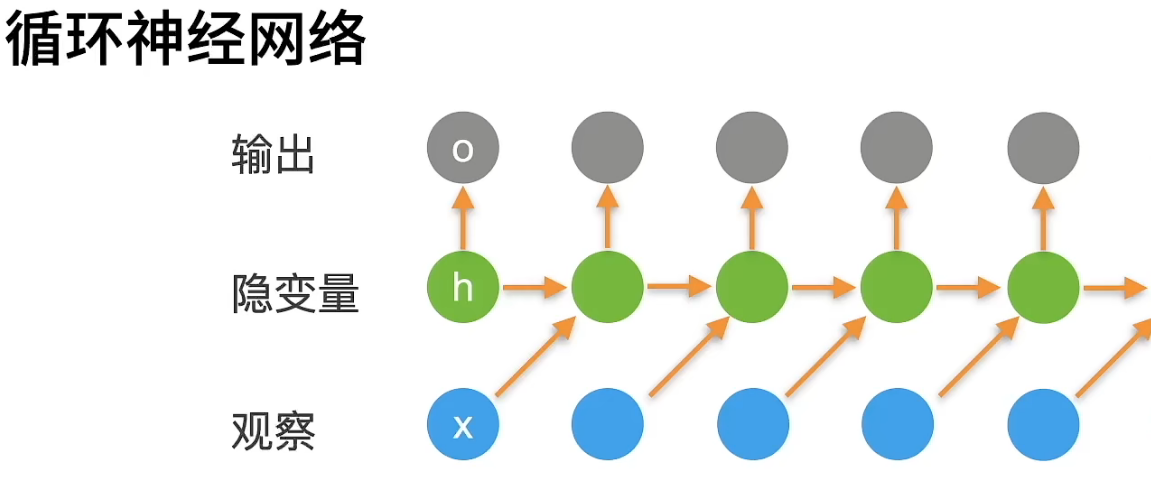

In [1]:
import torch
from d2l import torch as d2l

In [2]:
X, W_xh = torch.normal(0, 1, (3, 1)), torch.normal(0, 1, (1, 4))
H, W_hh = torch.normal(0, 1, (3, 4)), torch.normal(0, 1, (4, 4))
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-1.8497, -0.1985,  4.3095,  0.4414],
        [ 0.8262,  0.0521, -3.6085, -2.6526],
        [ 2.2894, -1.9796, -1.1521, -2.3807]])

现在，我们沿列（轴1）拼接矩阵`X`和`H`，
沿行（轴0）拼接矩阵`W_xh`和`W_hh`。
这两个拼接分别产生形状$(3, 5)$和形状$(5, 4)$的矩阵。
再将这两个拼接的矩阵相乘，
我们得到与上面相同形状$(3, 4)$的输出矩阵。


In [3]:
torch.matmul(torch.cat((X, H), 1), torch.cat((W_xh, W_hh), 0))

tensor([[-1.8497, -0.1985,  4.3095,  0.4414],
        [ 0.8262,  0.0521, -3.6085, -2.6526],
        [ 2.2894, -1.9796, -1.1521, -2.3807]])

## 基于循环神经网络的字符级语言模型

回想一下 :numref:`sec_language_model`中的语言模型，
我们的目标是根据过去的和当前的词元预测下一个词元，
因此我们将原始序列移位一个词元作为标签。
Bengio等人首先提出使用神经网络进行语言建模
 :cite:`Bengio.Ducharme.Vincent.ea.2003`。
接下来，我们看一下如何使用循环神经网络来构建语言模型。
设小批量大小为1，批量中的那个文本序列为“machine”。
为了简化后续部分的训练，我们考虑使用
*字符级语言模型*（character-level language model），
将文本词元化为字符而不是单词。
 :numref:`fig_rnn_train`演示了
如何通过基于字符级语言建模的循环神经网络，
使用当前的和先前的字符预测下一个字符。

![基于循环神经网络的字符级语言模型：输入序列和标签序列分别为“machin”和“achine”](../img/rnn-train.svg)
:label:`fig_rnn_train`

在训练过程中，我们对每个时间步的输出层的输出进行softmax操作，
然后利用交叉熵损失计算模型输出和标签之间的误差。
由于隐藏层中隐状态的循环计算，
 :numref:`fig_rnn_train`中的第$3$个时间步的输出$\mathbf{O}_3$
由文本序列“m”、“a”和“c”确定。
由于训练数据中这个文本序列的下一个字符是“h”，
因此第$3$个时间步的损失将取决于下一个字符的概率分布，
而下一个字符是基于特征序列“m”、“a”、“c”和这个时间步的标签“h”生成的。

在实践中，我们使用的批量大小为$n>1$，
每个词元都由一个$d$维向量表示。
因此，在时间步$t$输入$\mathbf X_t$将是一个$n\times d$矩阵，
这与我们在 :numref:`subsec_rnn_w_hidden_states`中的讨论相同。

## 困惑度（Perplexity）
:label:`subsec_perplexity`

最后，让我们讨论如何度量语言模型的质量，
这将在后续部分中用于评估基于循环神经网络的模型。
一个好的语言模型能够用高度准确的词元来预测我们接下来会看到什么。
考虑一下由不同的语言模型给出的对“It is raining ...”（“...下雨了”）的续写：

1. "It is raining outside"（外面下雨了）
1. "It is raining banana tree"（香蕉树下雨了）
1. "It is raining piouw;kcj pwepoiut"（piouw;kcj pwepoiut下雨了）

就质量而言，例$1$显然是最合乎情理、在逻辑上最连贯的。
虽然这个模型可能没有很准确地反映出后续词的语义，
比如，“It is raining in San Francisco”（旧金山下雨了）
和“It is raining in winter”（冬天下雨了）
可能才是更完美的合理扩展，
但该模型已经能够捕捉到跟在后面的是哪类单词。
例$2$则要糟糕得多，因为其产生了一个无意义的续写。
尽管如此，至少该模型已经学会了如何拼写单词，
以及单词之间的某种程度的相关性。
最后，例$3$表明了训练不足的模型是无法正确地拟合数据的。

我们可以通过计算序列的似然概率来度量模型的质量。
然而这是一个难以理解、难以比较的数字。
毕竟，较短的序列比较长的序列更有可能出现，
因此评估模型产生托尔斯泰的巨著《战争与和平》的可能性
不可避免地会比产生圣埃克苏佩里的中篇小说《小王子》可能性要小得多。
而缺少的可能性值相当于平均数。

在这里，信息论可以派上用场了。
我们在引入softmax回归
（ :numref:`subsec_info_theory_basics`）时定义了熵、惊异和交叉熵，
并在[信息论的在线附录](https://d2l.ai/chapter_appendix-mathematics-for-deep-learning/information-theory.html)
中讨论了更多的信息论知识。
如果想要压缩文本，我们可以根据当前词元集预测的下一个词元。
一个更好的语言模型应该能让我们更准确地预测下一个词元。
因此，它应该允许我们在压缩序列时花费更少的比特。
所以我们可以通过一个序列中所有的$n$个词元的交叉熵损失的平均值来衡量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1),$$
:eqlabel:`eq_avg_ce_for_lm`

其中$P$由语言模型给出，
$x_t$是在时间步$t$从该序列中观察到的实际词元。
这使得不同长度的文档的性能具有了可比性。
由于历史原因，自然语言处理的科学家更喜欢使用一个叫做*困惑度*（perplexity）的量。
简而言之，它是 :eqref:`eq_avg_ce_for_lm`的指数：

$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$

困惑度的最好的理解是“下一个词元的实际选择数的调和平均数”。
我们看看一些案例：

* 在最好的情况下，模型总是完美地估计标签词元的概率为1。
  在这种情况下，模型的困惑度为1。
* 在最坏的情况下，模型总是预测标签词元的概率为0。
  在这种情况下，困惑度是正无穷大。
* 在基线上，该模型的预测是词表的所有可用词元上的均匀分布。
  在这种情况下，困惑度等于词表中唯一词元的数量。
  事实上，如果我们在没有任何压缩的情况下存储序列，
  这将是我们能做的最好的编码方式。
  因此，这种方式提供了一个重要的上限，
  而任何实际模型都必须超越这个上限。

在接下来的小节中，我们将基于循环神经网络实现字符级语言模型，
并使用困惑度来评估这样的模型。

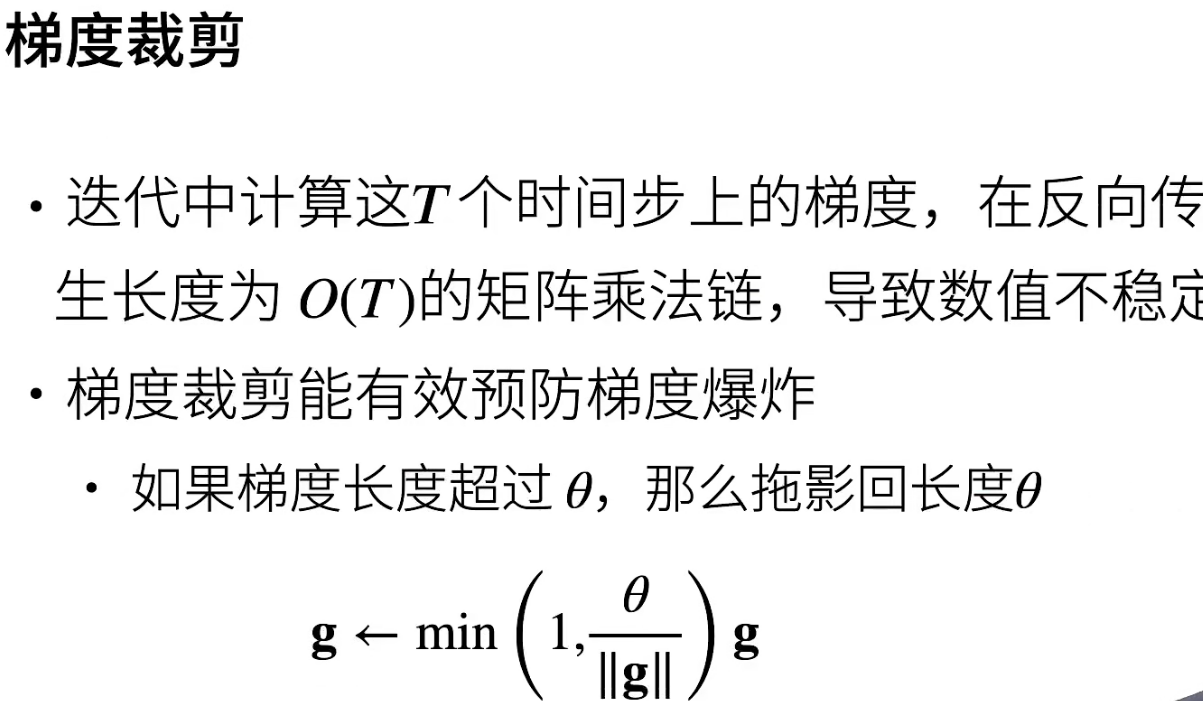
## 小结

* 对隐状态使用循环计算的神经网络称为循环神经网络（RNN）。
* 循环神经网络的隐状态可以捕获直到当前时间步序列的历史信息。
* 循环神经网络模型的参数数量不会随着时间步的增加而增加。
* 我们可以使用循环神经网络创建字符级语言模型。
* 我们可以使用困惑度来评价语言模型的质量。

## 练习

1. 如果我们使用循环神经网络来预测文本序列中的下一个字符，那么任意输出所需的维度是多少？
1. 为什么循环神经网络可以基于文本序列中所有先前的词元，在某个时间步表示当前词元的条件概率？
1. 如果你基于一个长序列进行反向传播，梯度会发生什么状况？
1. 与本节中描述的语言模型相关的问题有哪些？


1. 输出的维度应该与输入维度相同吧，因为在RNN中每一个输出由当下时间步t的输入和上一步传入的隐状态h_t-1决定
2. 隐状态h_t-1存储了到时间步 t−1 的序列信息
3. 如果序列比较长反向传播的时候梯度可能会出现消失或者爆炸的情况，所以要做梯度裁剪